In [1]:
dataset_name = 'wn-001'  # Dataset name
hampel_window_len = 5    # Hampel filter window length (half-window)
#generate_upper = TRUE    # Generate an upper threshold?
#generate_lower = FALSE   # Generate a lower threshold?
num_sigmas = 3           # Number of sigmas to use for generating the threshold

# Train constant threshold detector

Train a constant threshold detector on a given time series.

## Setup

In [2]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load("jsonlite", "pracma", "tidyverse")

library(jsonlite)
library(pracma)
library(tidyverse)

read.data <- function(name) {
    path <- paste("data/", name, ".csv", sep="")
    read_csv(path)
}

write.detector <- function(detector, name) {
    dir.create(file.path("out/detectors"), recursive=TRUE, showWarnings=FALSE)
    path <- paste("out/detectors/ct-", name, ".json", sep="")
    json <- toJSON(detector)
    write_json(detector, path)
}

Loading required package: pacman


## Import data

Import the dataset specified in the parameters.

In [3]:
data <- read.data(dataset_name)

Parsed with column specification:
cols(
  timestamps = col_datetime(format = ""),
  values = col_double()
)


In [4]:
head(data)

timestamps,values
<dttm>,<dbl>
2019-07-01 00:00:00,18.97582
2019-07-01 00:01:00,19.69517
2019-07-01 00:02:00,16.31331
2019-07-01 00:03:00,20.33165
2019-07-01 00:04:00,18.06066
2019-07-01 00:05:00,19.99455


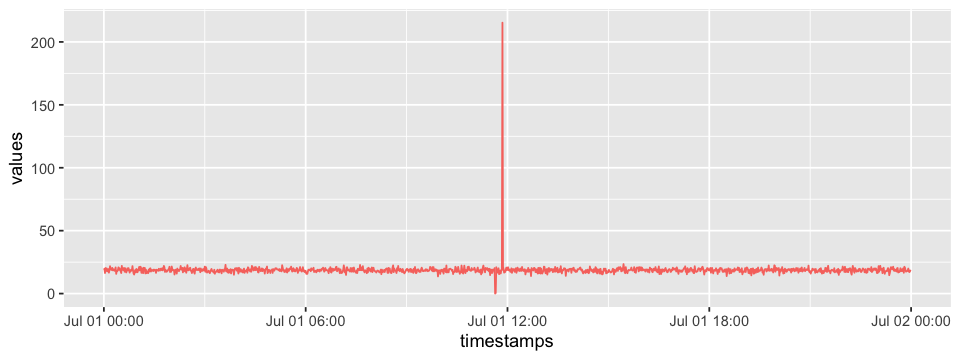

In [5]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(data=data) +
  geom_line(mapping=aes(x=timestamps, y=values, color="values"), show.legend=FALSE)

## Clean data

In [6]:
values.clean <- hampel(x=data$values, k=hampel_window_len)$y
data.clean <- add_column(data, values.clean)

In [7]:
head(data.clean)

timestamps,values,values.clean
<dttm>,<dbl>,<dbl>
2019-07-01 00:00:00,18.97582,18.97582
2019-07-01 00:01:00,19.69517,19.69517
2019-07-01 00:02:00,16.31331,16.31331
2019-07-01 00:03:00,20.33165,20.33165
2019-07-01 00:04:00,18.06066,18.06066
2019-07-01 00:05:00,19.99455,19.99455


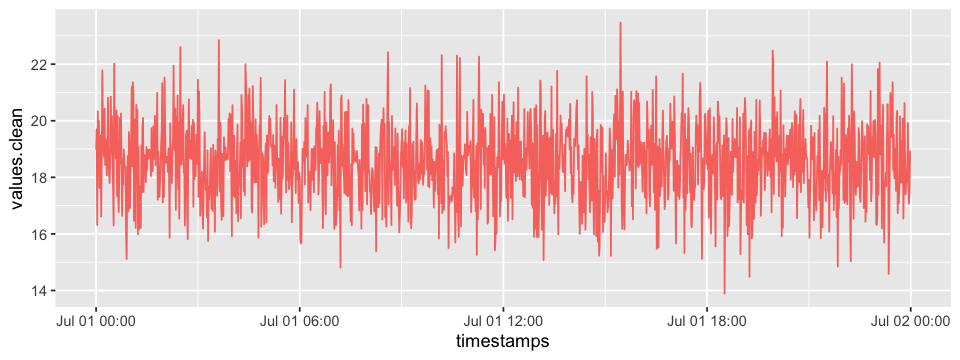

In [8]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(data=data.clean) +
  geom_line(mapping=aes(x=timestamps, y=values.clean, color="values"), show.legend=FALSE)

## Build detector

In [9]:
mu <- mean(data.clean$values.clean)
sigma <- sd(data.clean$values.clean)
upper <- mu + num_sigmas * sigma
lower <- mu - num_sigmas * sigma
tibble(mu, sigma, upper, lower)

mu,sigma,upper,lower
<dbl>,<dbl>,<dbl>,<dbl>
18.54289,1.390241,22.71361,14.37216


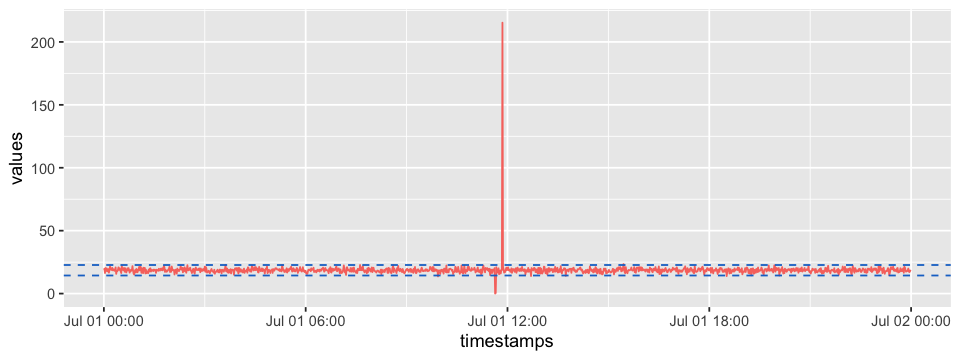

In [10]:
ggplot(data=data) +
  geom_line(mapping=aes(x=timestamps, y=values, color="values"), show.legend=FALSE) +
  geom_hline(yintercept=upper, linetype="dashed", color="dodgerblue3") +
  geom_hline(yintercept=lower, linetype="dashed", color="dodgerblue3")

## Write detector

In [11]:
detector <- list(upper=unbox(upper), lower=unbox(lower))
write.detector(detector, dataset_name)